# Transfer Matrices in Python

<a href="https://en.wikipedia.org/wiki/Transfer_matrix" target="_blank">Transfer matrices</a> are one of the many methods used to solve for the propagation of waves across a system. For example, this method can be used in quantum mechanics to solve for the <a href="https://en.wikipedia.org/wiki/Schrödinger_equation" target="_blank">Schrödinger equation</a>, as well as for the propagation of <a href="https://en.wikipedia.org/wiki/Transfer-matrix_method_(optics)" target="_blank">electromagnetic waves</a>. Simply put, the transfer matrix __T__ is a 2 × 2 matrix that relates the complex quantum mechanical wave function at position __x__<sub>0</sub> to another position at __x__<sub>1</sub> through the linear relation: 

__ψ__(__x__<sub>0</sub>) = __T__(__x__<sub>1</sub>, __x__<sub>0</sub>)__ψ__(__x__<sub>1</sub>). 

In this post, we will explore how to calculate the transfer matrix for a 1D quantum mechanical system in Python. 

## The Transfer Matrix

We will focus on implementing the quantum mechanical calculations in Python, and will not derive any of the mathematical details used. For those who want to know more about the mathematical details on the derivations of the various operations used, these <a href="http://www1.spms.ntu.edu.sg/~ydchong/teaching/PH4401_Appendix_B_transfer_matrix.pdf" target="_blank">notes by Prof. Chong Yidong</a> from NTU are a good start. 

The transfer matrix can be calculated using two basic operations: a jump across two adjacent potential steps, and a translation across a potential step. By combining multiple iterations of these 2 operations together for the various potential steps in a potential well, we can determine the transfer matrix for a particle traveling from one end of the well to the other end. The jump across two adjacent potential steps can be calculated using the function below.

In [1]:
import numpy as np
from numpy.lib.scimath import sqrt
import matplotlib.pyplot as plt
from scipy import linalg

def jump(k_0, k_1):
    """
    Calculates the transfer matrix for jumps across
    potential steps.
 
    Inputs
    ------
    k_0: wave number on the left of the step.
    k_1: wave number on the right of the step.

    Returns
    -------
    J: transfer matrix for jumps.
    """
    if k_1 == 0: # to address zero division...
        k_1 = k_0 * 0.01
    J = np.array([[1 + k_0 / k_1, 1 - k_0 / k_1], 
                  [1 - k_0 / k_1, 1 + k_0 / k_1]])
    return J / 2.0

The translation across a potential step of length _L_ can be calculated using the following function.

In [2]:
def translate(k, L):
    """
    Calculates the transfer matrix for translations
    along potential steps.
 
    Inputs
    ------
    k: wave number for along the potential step.
    L: length of the potential step.

    Returns
    -------
    T: transfer matrix for translations.
    """
    T = np.array([[np.exp(1j * k * L), 0], 
                  [0, np.exp(-1j * k * L)]])
    return T

Using the two basic operations for jumps and translations, the transfer matrix for a 1D quantum mechanical system defined by a particle with energy _E_, a potential well with potential steps _V_ and length _L_, and external (reference) potential _V_<sub>0</sub> can be calculated using the function below. Note that the `sqrt` function used is from `numpy.lib.scimath` instead of `numpy`, which handles complex numbers properly.

In [3]:
def transfer_matrix(E, V, L, V0):
    """
    This function calculates the transfer matrix 
    for a series of quantum potentials.
    
    This code assumes that V0 is the same on both 
    sides of the potential well.
    This code assumes that E != V.
    
    Inputs
    ------
    E: float, particle energy.
    V: np.array, potential steps.
    L: np.array, potential step lengths.
    V0: float, potential on both sides of the well.
    
    Returns
    -------
    transfer: np.array, 2 x 2 transfer matrix.
    """

    assert len(V) == len(L)
    N = len(L)
    V = np.append(V, V0) 
    k = sqrt(E - V)
 
    # Calculate the first potential jump from V0 to V[0]
    transfer = jump(sqrt(E - V0), k[0])

    # Loop over the remaining potential steps
    for n in range(N):
        # Translate across V[n]:
        Translate = translate(k[n], L[n])
        # Jump from V[n] to V[n+1]:
        Jump = jump(k[n], k[n + 1])
        transfer = np.dot(Translate, transfer)
        transfer = np.dot(Jump, transfer)
        
    return transfer

In order to explore how to use the results of this function, we explore the reflection and transmission coefficients of a particle impinging on a potential step. The reflection coefficient can be calculated from the transfer matrix __T__ using the relation: 

`Re = np.abs(T[1, 0] / T[1, 1]) ** 2`, 

while the corresponding transmission coefficient can be calculated using the relation: 

`Tr = np.abs(linalg.det(T) / T[1, 1]) ** 2`. 

Together with the reflection and transmission coefficients calculated from the transfer matrix __T__, we plot the positions of the theoretical eigenvalues of a particle trapped in a box, given by the equation: 

_E_<sub>eig</sub> = <i>n</i><sup>2</sup><i>ħ</i><sup>2</sup>π<sup>2</sup>/2<i>mL</i><sup>2</sup> + <i>V</i>.

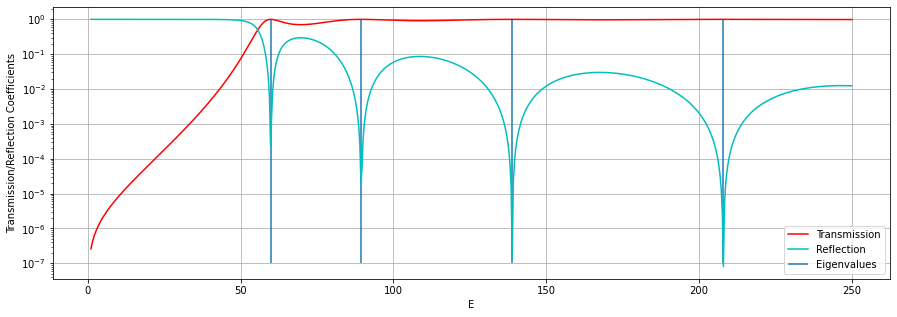

In [4]:
# List of particle energies to consider
E = np.linspace(1, 250, 700) 
# Potential is a single step with V = 50
V = np.array([50])
# and L = 1
L = np.array([1])
# The external (reference) potential is V0 = 0
V0 = 0

# Transmission coefficient results
Tr = np.zeros(len(E))  
# Reflection coefficient results
Re = np.zeros(len(E))
    
for i in range(len(E)):
    T = transfer_matrix(E[i], V, L, V0)  
    # Reflection coefficient
    Re[i] = np.abs(T[1, 0] / T[1, 1]) ** 2 
    # Transmission coefficient
    Tr[i] = np.abs(linalg.det(T) / T[1, 1]) ** 2   
        
# Eigenvalues of particle in a box are:
# H = n^2 hbar^2 pi^2 / 2 m L^2 + V
# we have normalised hbar^2/2 m = 1:
n = np.array([1, 2, 3, 4])
H = (n ** 2) * (np.pi ** 2) + 50

plt.figure(figsize=(15, 5))
plt.semilogy(E, Tr, 'r')
plt.semilogy(E, Re, 'c')
plt.vlines(H, 1e-7, 1)
plt.legend(["Transmission", 
            "Reflection", 
            "Eigenvalues"])
plt.xlabel('E')
plt.ylabel('Transmission/Reflection Coefficients')
plt.grid(True)
plt.show()

Generally, the transmission curve increases from a miminum to a maximum transmission past the value of _E_ = _V_ = 50, while the reflection remains near the maximum value and starts to decrease past the same value. The region of _E_ < 50 corresponds to the classical regime where the particle cannot overcome the potential barrier due to it having a lower energy than the potential barrier. However in the quantum mechanical regime, the particle has a very small chance that it can tunnel through the barrier.

The interesting feature is that past _E_ = 50 the reflection transmission does not decay gradually i.e. the curve is not well behaved, there are some sharp dips in the curve at certain values of _E_, and these sharp dips occur at the energies which are the same as those of energy eigenvalues of a particle trapped in a box. Additionally, these sharp dips of the reflection curve coincide with a transmission value of 1 in the transmission curve; i.e. the transmission coefficient equals 1 only for certain values of _E_ rather than for all values of _E_ > _V_.

The transmission coefficient equals 1 only when the width of the barrier is half-integral or full-integral of the de Broglie wavelength of the particle within the potential step. Working out the mathematical details leads to the analytical result that the energy of the particle follows the form of the energy eigenvalues of a particle in a box: 

_E_<sub>eig</sub> = <i>n</i><sup>2</sup><i>ħ</i><sup>2</sup>π<sup>2</sup>/2<i>mL</i><sup>2</sup> + <i>V</i>.

This is a result of destructive interference between reflections of the quantum mechanical wave functions at the two edges of the potential step.

***

## References

* <a href="http://www1.spms.ntu.edu.sg/~ydchong/teaching/PH4401_Appendix_B_transfer_matrix.pdf" target="_blank">The Transfer Matrix Method, YD Chong</a>.

* <a href="https://www.amazon.com/Quantum-Mechanics-Vol-Albert-Messiah/dp/B000LCEXBY" target="_blank">Quantum Mechanics Vol 1, A. Messiah Pgs 88-98</a>.

* <a href="https://www.amazon.com/Quantum-Mechanics-2nd-B-H-Bransden/dp/0582356911" target="_blank">Quantum Mechanics 2nd Edition, Bransden and Joachain Pgs 154-155</a>.

* <a href="https://www.amazon.com/Introduction-Quantum-Mechanics-David-Griffiths/dp/1107179866" target="_blank">Introduction to Quantum Mechanics 2nd Edition, D. Griffiths Pg 82</a>.